In [1]:
import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

%run kernel_grid.ipynb

print(f'Process ID: {os.getpid()}')

4.51 μs ± 134 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
4.82 μs ± 53.2 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
Started pool with 12 workers, chunk size = 21
Process ID: 1460587


In [2]:
config = Config()

In [3]:
%%time
images = []

for image_fname in tqdm(os.listdir(config.dataset_path)):
    image_fname = os.path.join(config.dataset_path, image_fname)

    # Following fuss with "with" is required to prevent "Too many open files" problem
    with Image.open(image_fname) as image:
        image.load()
        assert image.width == image.height
        assert image.mode == 'L'
        images.append((image_fname, np.array(image)))
        
    assert image.fp is None

print(f'Loaded {len(images)} images')

  0%|          | 0/3000 [00:00<?, ?it/s]

Loaded 3000 images
CPU times: user 157 ms, sys: 16 ms, total: 173 ms
Wall time: 171 ms


In [4]:
images[0]

('dataset/dataset_source_101_ObjectCategories_cougar_face_image_0061@139,150.png',
 array([[ 0,  0,  0, ..., 15, 11,  0],
        [ 0,  0,  0, ...,  0,  5, 17],
        [ 0, 18,  8, ...,  0, 17, 26],
        ...,
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  7, 15, ...,  0,  0,  1],
        [ 3,  1, 11, ...,  0,  0,  0]], shape=(32, 32), dtype=uint8))

In [5]:
grid = KernelGrid.random(config.kernel_grid_size, config.kernel_size)

In [6]:
def get_day_images():
    return images

In [8]:
def enhance(extinct_waterline):
    assert extinct_waterline > 0 and extinct_waterline < 1
    
    k_perf_scores = []
    
    for ij, k in grid.indices.items():
        assert k.match_invokes > 0
        ks = k.get_stats()
        k_perf_score_mac = ks.complexity >= config.kernel_min_complexity
        k_perf_score_mac = k_perf_score_mac and ks.match_success_rate > 0
        k_perf_score = int(k_perf_score_mac) * ks.match_score
        k_perf_scores.append((k_perf_score, k, ij))
    
    k_perf_scores.sort(key=lambda x: x[0])
    extinct_list_hi = int(len(k_perf_scores) * extinct_waterline)
    assert extinct_list_hi > 0 and extinct_list_hi < len(k_perf_scores)
    extinct_list = k_perf_scores[0:extinct_list_hi]
    extinct_list_ijs = set([ij for _1, _2, ji in extinct_list])
    assert len(extinct_list) < len(k_perf_scores)
    
    new_kernels = dict()
    
    for k_perf_score, k, ij in extinct_list:
        ns = grid.get_neighbours(ij)
        possible_parents = []
    
        for n_ij, n_k in ns:
            can_spawn_children = True
            can_spawn_children = can_spawn_children and not n_ij in extinct_list_ijs
            can_spawn_children = can_spawn_children and not isinstance(n_k, FenceKernel)
            
            if can_spawn_children:
                assert n_k.match_invokes > 0, n_ij
                possible_parents.append(n_k)
    
        possible_parents.sort(key=lambda k: k.get_stats().match_success_rate, reverse=True)
        parent = None
    
        if possible_parents:
            # TODO randombly pick up parent giving favor to more performant
            parent = possible_parents[0]
    
        if parent:
            new_kernel = parent.spawn_child()
        else:
            new_kernel = Kernel.random(config.kernel_size)
    
        new_kernels[ij] = new_kernel
    
    for ij, _ in new_kernels.items():
        assert ij in grid.indices
        
    grid.indices.update(new_kernels)

In [9]:
%%time
train_stats = []

# for day in range(config.kernel_grid_evolution_days):
for day in range(100):
    # Make day impressions
    day_images = get_day_images()
    grid.reset_stats()

    for image in tqdm(day_images, desc=f'Day #{day}'):
        image_data = image[1]
        grid.perceive(image_data, config.kernel_match_threshold, config.kernel_grid_match_threshold)

    assert grid.perceive_invokes > 0
    grid_stats = grid.get_stats()
    train_stats.append(grid_stats)

    # Adjust kernels to better match day impressions
    enhance(0.5)

Day #0:   0%|          | 0/3000 [00:00<?, ?it/s]

Day #1:   0%|          | 0/3000 [00:00<?, ?it/s]

Day #2:   0%|          | 0/3000 [00:00<?, ?it/s]

Day #3:   0%|          | 0/3000 [00:00<?, ?it/s]

Day #4:   0%|          | 0/3000 [00:00<?, ?it/s]

Day #5:   0%|          | 0/3000 [00:00<?, ?it/s]

Day #6:   0%|          | 0/3000 [00:00<?, ?it/s]

Day #7:   0%|          | 0/3000 [00:00<?, ?it/s]

Day #8:   0%|          | 0/3000 [00:00<?, ?it/s]

Day #9:   0%|          | 0/3000 [00:00<?, ?it/s]

Day #10:   0%|          | 0/3000 [00:00<?, ?it/s]

Day #11:   0%|          | 0/3000 [00:00<?, ?it/s]

Day #12:   0%|          | 0/3000 [00:00<?, ?it/s]

Day #13:   0%|          | 0/3000 [00:00<?, ?it/s]

Day #14:   0%|          | 0/3000 [00:00<?, ?it/s]

Day #15:   0%|          | 0/3000 [00:00<?, ?it/s]

Day #16:   0%|          | 0/3000 [00:00<?, ?it/s]

Day #17:   0%|          | 0/3000 [00:00<?, ?it/s]

Day #18:   0%|          | 0/3000 [00:00<?, ?it/s]

Day #19:   0%|          | 0/3000 [00:00<?, ?it/s]

Day #20:   0%|          | 0/3000 [00:00<?, ?it/s]

Day #21:   0%|          | 0/3000 [00:00<?, ?it/s]

Day #22:   0%|          | 0/3000 [00:00<?, ?it/s]

Day #23:   0%|          | 0/3000 [00:00<?, ?it/s]

Day #24:   0%|          | 0/3000 [00:00<?, ?it/s]

Day #25:   0%|          | 0/3000 [00:00<?, ?it/s]

Day #26:   0%|          | 0/3000 [00:00<?, ?it/s]

Day #27:   0%|          | 0/3000 [00:00<?, ?it/s]

Day #28:   0%|          | 0/3000 [00:00<?, ?it/s]

Day #29:   0%|          | 0/3000 [00:00<?, ?it/s]

Day #30:   0%|          | 0/3000 [00:00<?, ?it/s]

Day #31:   0%|          | 0/3000 [00:00<?, ?it/s]

Day #32:   0%|          | 0/3000 [00:00<?, ?it/s]

Day #33:   0%|          | 0/3000 [00:00<?, ?it/s]

Day #34:   0%|          | 0/3000 [00:00<?, ?it/s]

Day #35:   0%|          | 0/3000 [00:00<?, ?it/s]

Day #36:   0%|          | 0/3000 [00:00<?, ?it/s]

Day #37:   0%|          | 0/3000 [00:00<?, ?it/s]

Day #38:   0%|          | 0/3000 [00:00<?, ?it/s]

Day #39:   0%|          | 0/3000 [00:00<?, ?it/s]

Day #40:   0%|          | 0/3000 [00:00<?, ?it/s]

Day #41:   0%|          | 0/3000 [00:00<?, ?it/s]

Day #42:   0%|          | 0/3000 [00:00<?, ?it/s]

Day #43:   0%|          | 0/3000 [00:00<?, ?it/s]

Day #44:   0%|          | 0/3000 [00:00<?, ?it/s]

Day #45:   0%|          | 0/3000 [00:00<?, ?it/s]

Day #46:   0%|          | 0/3000 [00:00<?, ?it/s]

Day #47:   0%|          | 0/3000 [00:00<?, ?it/s]

Day #48:   0%|          | 0/3000 [00:00<?, ?it/s]

Day #49:   0%|          | 0/3000 [00:00<?, ?it/s]

Day #50:   0%|          | 0/3000 [00:00<?, ?it/s]

Day #51:   0%|          | 0/3000 [00:00<?, ?it/s]

Day #52:   0%|          | 0/3000 [00:00<?, ?it/s]

Day #53:   0%|          | 0/3000 [00:00<?, ?it/s]

Day #54:   0%|          | 0/3000 [00:00<?, ?it/s]

Day #55:   0%|          | 0/3000 [00:00<?, ?it/s]

Day #56:   0%|          | 0/3000 [00:00<?, ?it/s]

Day #57:   0%|          | 0/3000 [00:00<?, ?it/s]

Day #58:   0%|          | 0/3000 [00:00<?, ?it/s]

Day #59:   0%|          | 0/3000 [00:00<?, ?it/s]

Day #60:   0%|          | 0/3000 [00:00<?, ?it/s]

Day #61:   0%|          | 0/3000 [00:00<?, ?it/s]

Day #62:   0%|          | 0/3000 [00:00<?, ?it/s]

Day #63:   0%|          | 0/3000 [00:00<?, ?it/s]

Day #64:   0%|          | 0/3000 [00:00<?, ?it/s]

Day #65:   0%|          | 0/3000 [00:00<?, ?it/s]

Day #66:   0%|          | 0/3000 [00:00<?, ?it/s]

Day #67:   0%|          | 0/3000 [00:00<?, ?it/s]

Day #68:   0%|          | 0/3000 [00:00<?, ?it/s]

Day #69:   0%|          | 0/3000 [00:00<?, ?it/s]

Day #70:   0%|          | 0/3000 [00:00<?, ?it/s]

Day #71:   0%|          | 0/3000 [00:00<?, ?it/s]

Day #72:   0%|          | 0/3000 [00:00<?, ?it/s]

Day #73:   0%|          | 0/3000 [00:00<?, ?it/s]

Day #74:   0%|          | 0/3000 [00:00<?, ?it/s]

Day #75:   0%|          | 0/3000 [00:00<?, ?it/s]

Day #76:   0%|          | 0/3000 [00:00<?, ?it/s]

Day #77:   0%|          | 0/3000 [00:00<?, ?it/s]

Day #78:   0%|          | 0/3000 [00:00<?, ?it/s]

Day #79:   0%|          | 0/3000 [00:00<?, ?it/s]

Day #80:   0%|          | 0/3000 [00:00<?, ?it/s]

Day #81:   0%|          | 0/3000 [00:00<?, ?it/s]

Day #82:   0%|          | 0/3000 [00:00<?, ?it/s]

Day #83:   0%|          | 0/3000 [00:00<?, ?it/s]

Day #84:   0%|          | 0/3000 [00:00<?, ?it/s]

Day #85:   0%|          | 0/3000 [00:00<?, ?it/s]

Day #86:   0%|          | 0/3000 [00:00<?, ?it/s]

Day #87:   0%|          | 0/3000 [00:00<?, ?it/s]

Day #88:   0%|          | 0/3000 [00:00<?, ?it/s]

Day #89:   0%|          | 0/3000 [00:00<?, ?it/s]

Day #90:   0%|          | 0/3000 [00:00<?, ?it/s]

Day #91:   0%|          | 0/3000 [00:00<?, ?it/s]

Day #92:   0%|          | 0/3000 [00:00<?, ?it/s]

Day #93:   0%|          | 0/3000 [00:00<?, ?it/s]

Day #94:   0%|          | 0/3000 [00:00<?, ?it/s]

Day #95:   0%|          | 0/3000 [00:00<?, ?it/s]

Day #96:   0%|          | 0/3000 [00:00<?, ?it/s]

Day #97:   0%|          | 0/3000 [00:00<?, ?it/s]

Day #98:   0%|          | 0/3000 [00:00<?, ?it/s]

Day #99:   0%|          | 0/3000 [00:00<?, ?it/s]

CPU times: user 8min 39s, sys: 1.39 s, total: 8min 41s
Wall time: 8min 40s


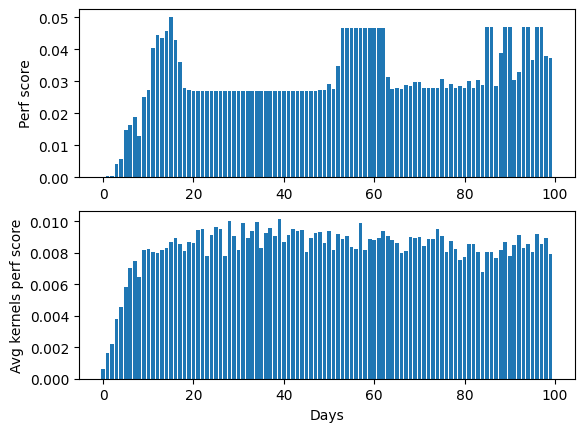

In [10]:
fig, ax = plt.subplots(2)
days_count = len(train_stats)
ax[0].bar(list(range(days_count)), [ts.perceive_success_rate for ts in train_stats])
ax[0].set_ylabel('Perf score')

ax[1].bar(list(range(days_count)), [ts.kernels_match_success_rates.mean for ts in train_stats])
ax[1].set_xlabel('Days')
ax[1].set_ylabel('Avg kernels perf score')
plt.show()


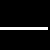
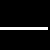
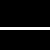
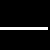
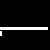
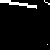
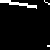
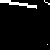
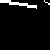
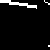
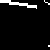
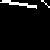
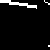
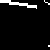
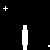
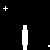
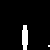
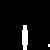
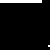
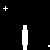
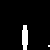
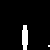
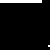
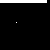
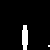
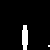
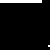
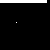
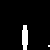
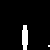
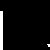
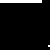
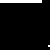
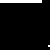
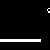
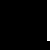
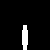
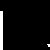
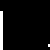
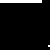
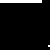
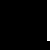
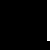
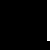
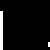
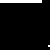
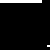
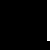
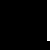
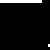
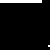
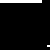
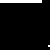
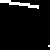
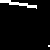
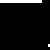
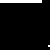
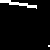
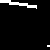
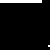
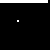
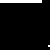
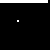
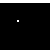
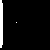
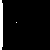
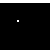
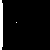
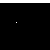
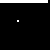
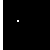
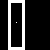
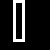
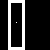
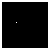
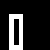
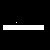
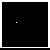
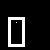
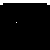
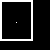
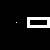
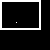
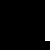
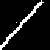
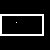
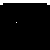
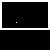
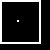
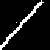
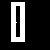
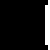
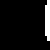
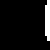
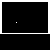
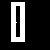
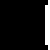
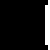
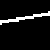
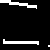
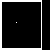
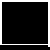
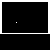
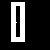
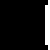
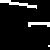
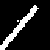
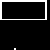
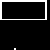
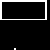
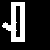
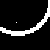
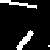
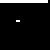
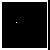
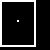
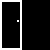
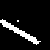
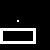
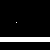
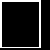
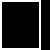
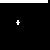
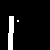
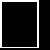
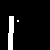
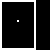
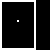
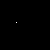
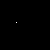
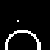
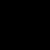
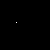
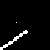
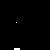
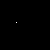
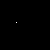
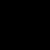
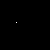
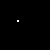
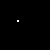
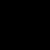
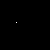
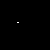
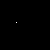
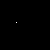
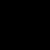
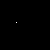
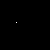
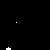
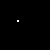
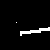
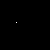
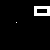
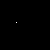
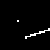
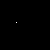
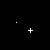
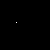
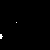
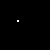
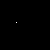
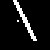
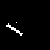
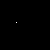
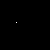
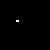
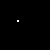
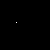
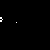
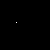
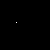
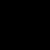
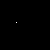
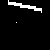
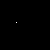
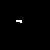
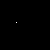
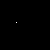
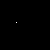
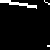
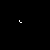
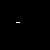
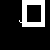
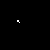
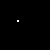
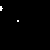
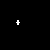
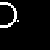
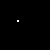
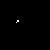
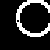
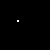
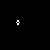
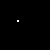
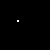
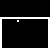
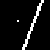
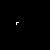
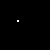
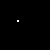
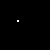
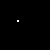
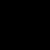
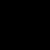
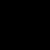
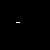
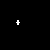
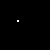
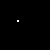
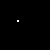
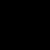
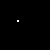
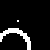
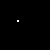
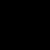
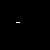
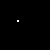
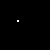
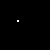
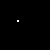
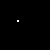
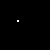
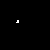
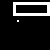
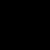
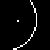
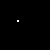
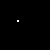
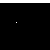
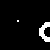
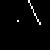
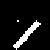
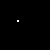
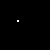
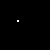
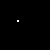
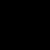
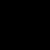
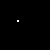
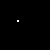
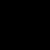
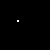
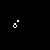
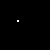
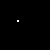
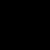
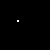
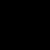
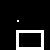
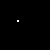
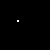
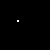
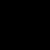
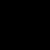
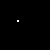

In [13]:
kernel_images = grid.get_kernel_images(1)
kernel_images.sort(key=lambda ki: ki.kernel.get_stats().match_success_rate, reverse=True)
images = []
captions = {}

for ki in kernel_images:
    image = ki.image.resize((50, 50))
    images.append(image)
    captions[id(image)] = f'{ki.kernel.get_stats().match_success_rate * 100:.2f}%'

display_images_grid(images, grid.size, captions=captions)

In [ ]:
ops1 = grid.indices[(15,15)].genotype.ops
ops2 = grid.indices[(13,13)].genotype.ops
ops1 == ops2